# Dog breed identification by picture

https://www.kaggle.com/competitions/dog-breed-identification/

## 1. Presentation of the problem

“Dog breed identification by picture” - it’s pretty self-explanatory. In other words:
We give the AI model an image of a dog (as an input) and want to get back the breed of the dog (as an output).

## 2. Data set
Working with images means that we are dealing with “unstructured data”.

2 folders:  
train - containing 10,223 images (382.7 MB) for training the model  
test - containing 10,358 images (384.3 MB) for testing the model  

2 CSV files:  
labels.csv - having two columns: id and breed. Contains the correct breed for every image in the ‘train’ folder.  
sample_submission.csv - an example file of how the predictions should be arranged to be a valid submission file for the Kaggle competition (of course it is not needed to train the model)

## 3. Presentation of the solution

First of all we will need to install all the modules we will be using for the project and import them.  
The used modules are: numpy, pandas, matplotlib.pyplot, scikit-learn, tensorflow and tensorflow_hub (plus datetime and os).

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow tensorflow_hub

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import datetime
import os

### 3.1. Process the data

In [ ]:
labels_csv = pd.read_csv("data_set/labels.csv")

labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
filenames = ["./data_set/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['./data_set/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 './data_set/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 './data_set/train/001cdf01b096e06d78e9e5112d419397.jpg',
 './data_set/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 './data_set/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 './data_set/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 './data_set/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 './data_set/train/002a283a315af96eaea0e28e7163b21b.jpg',
 './data_set/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 './data_set/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

<AxesSubplot: >

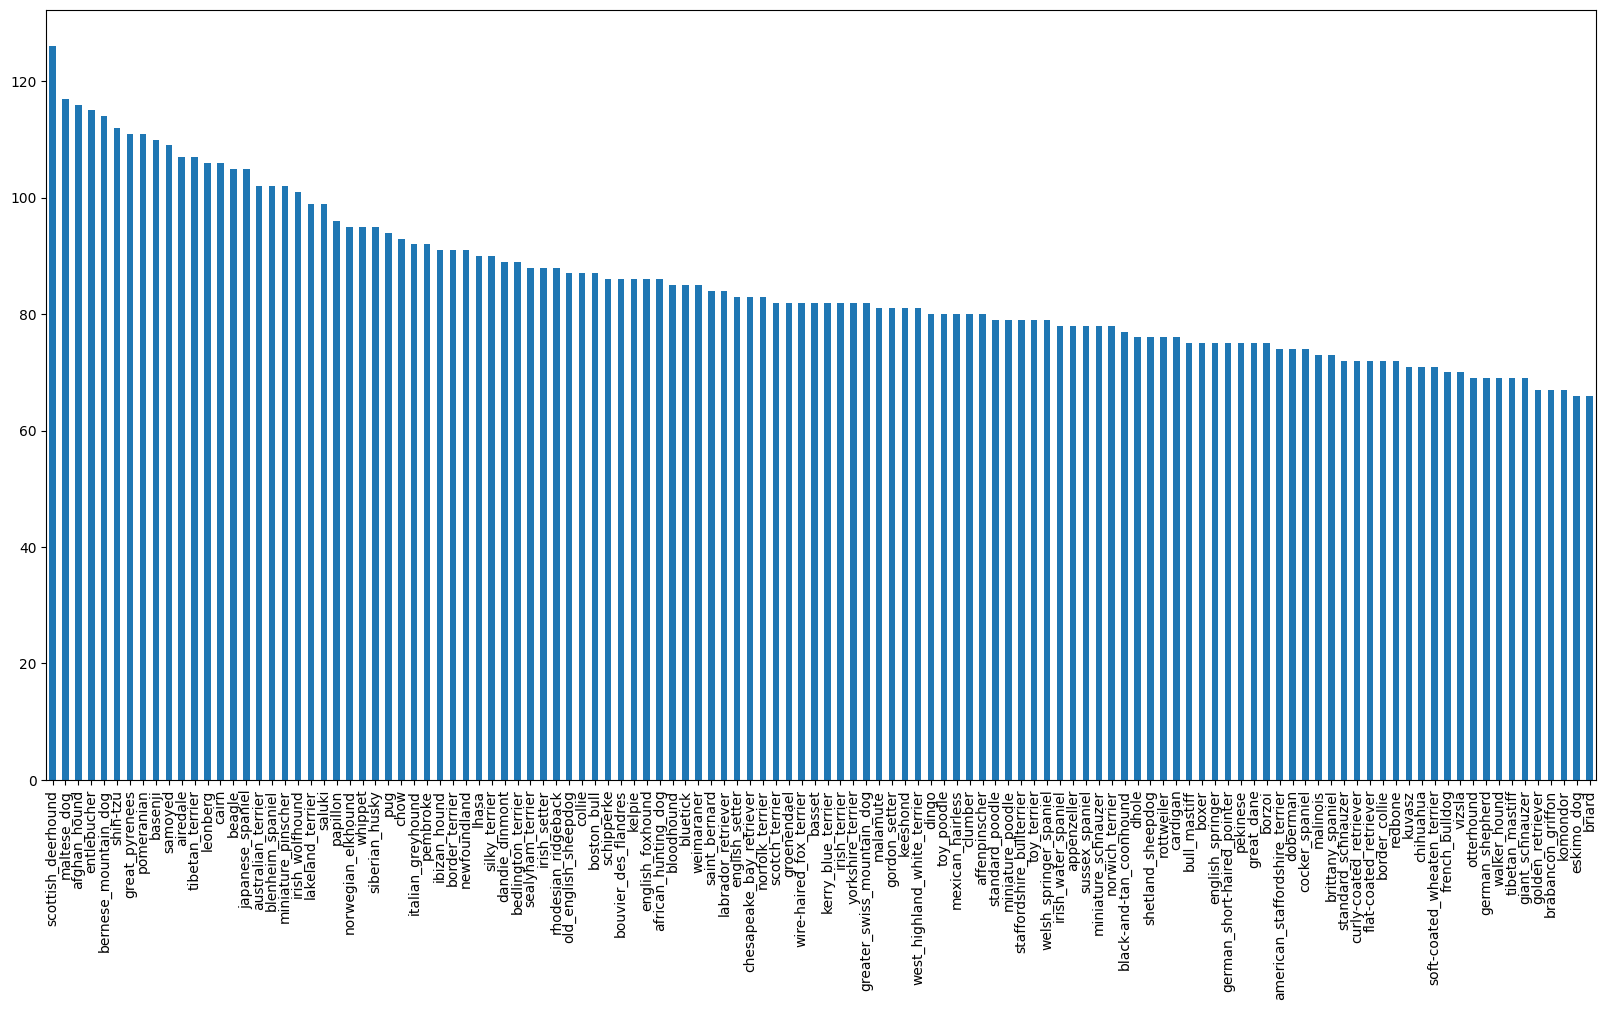

In [ ]:
# INTERESTING
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
labels = labels_csv["breed"]
labels = np.array(labels)

# All the labels
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
unique_breeds = np.unique(labels)

# Nr of labels
len(unique_breeds)

120

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]

# An example of a label turned into a boolean array
boolean_labels[:1]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False])]

#### Create a validation data set (because Kaggle doesn't provided one)

In [ ]:
# Setup x and y variables
x = filenames
y = boolean_labels

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000

In [ ]:
# Split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2)

len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Check one of the x and y variables
x_train[:1], y_train[:1]

(['./data_set/train/0042188c895a2f14ef64a918ed9c7b64.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
    

#### Preprocessing images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input.
2. Use TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpg) into Tensors.
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224).
6. Return the modified `image`.

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 color channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

#### Turning our data into batches  
10,000+ images most likely won't fit into the memory. So we need to feed the model in batches.  
The form which TensorFlow works well looks like this: `(image, label)`.

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)

  return image, label

In [ ]:
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation
  data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")

    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(batch_size)

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")

    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels

    data_batch = data.map(get_image_label).batch(batch_size)

  else:
    print("Creating training data batches...")

    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(batch_size)

  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


2022-12-17 17:24:24.867468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [ ]:
# INTERESTING
plt.rc('font', size=8)

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))

  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i + 1)

    # Display an image
    plt.imshow(images[i])

    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])

    # Turn the grid lines off
    plt.axis("off")

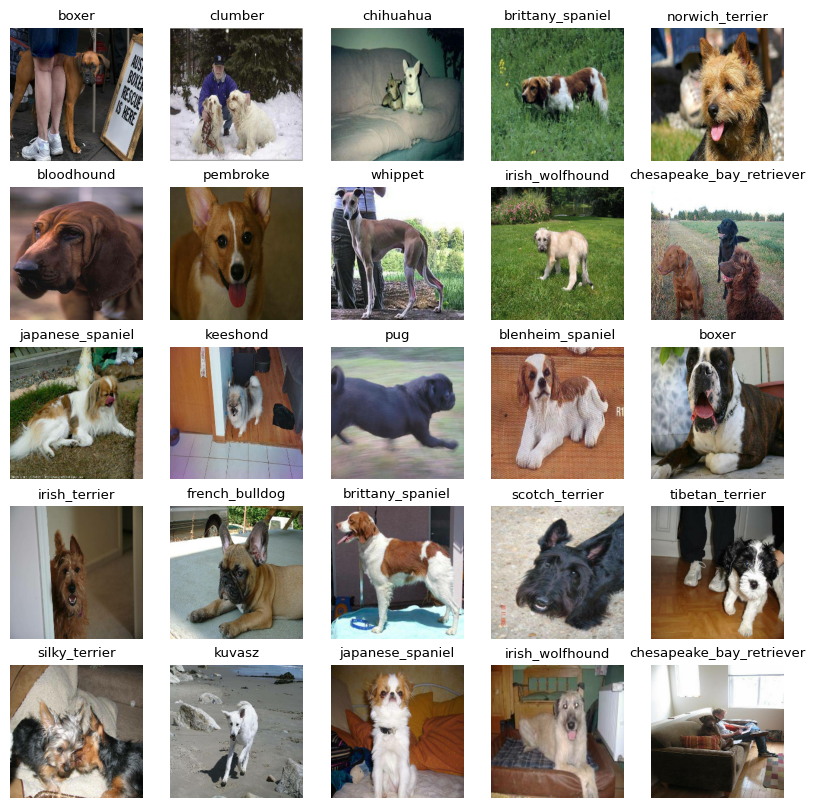

In [ ]:
# INTERESTING
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())

show_25_images(train_images, train_labels)

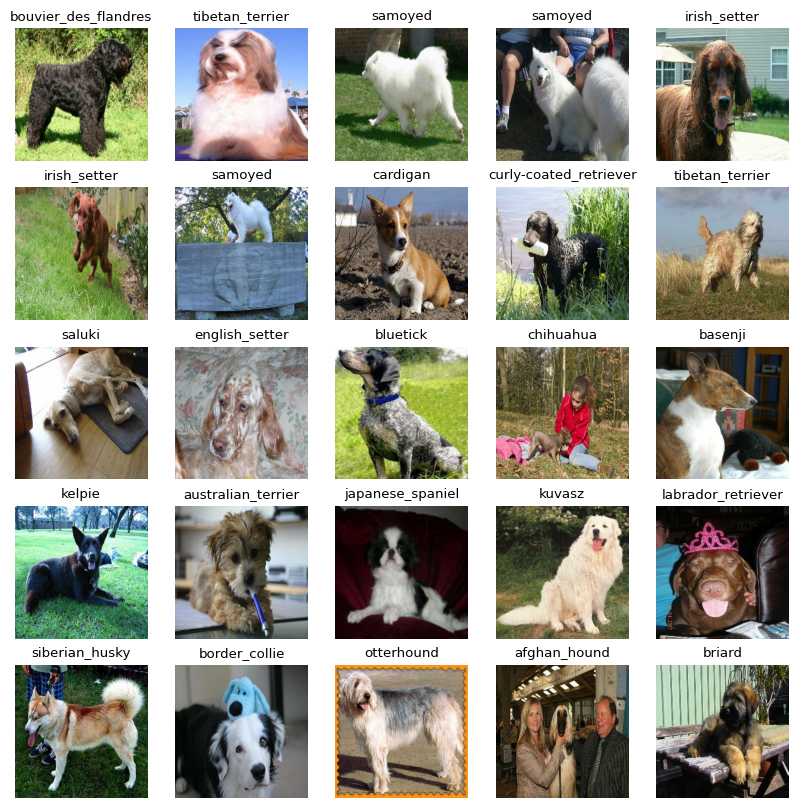

In [ ]:
# INTERESTING
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())

show_25_images(val_images, val_labels)

### 3.2. Build (train) the model

Before building the model we should define the input shape, the output shape and the model we want to use from TensorFlow Hub.

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", model_url)

  # Setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # Layer 1 (input layer)
      tf.keras.layers.Dense(units=output_shape, activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(input_shape)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


#### Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.
#### TensorBoard Callback


To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

#### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [ ]:
NUM_EPOCHS = 100

Let's create a function which trains a model:

* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()`.
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return the model.

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(
      x=train_data,
      epochs=NUM_EPOCHS,
      validation_data=val_data,
      validation_freq=1,
      callbacks=[tensorboard, early_stopping]
  )

  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 19s 672ms/step - loss: 4.6159 - accuracy: 0.0812 - val_loss: 3.4468 - val_accuracy: 0.2600
Epoch 2/100
25/25 [==============================] - 16s 645ms/step - loss: 1.6124 - accuracy: 0.7088 - val_loss: 2.1508 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 16s 645ms/step - loss: 0.5411 - accuracy: 0.9488 - val_loss: 1.7005 - val_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 16s 649ms/step - loss: 0.2365 - accuracy: 0.9900 - val_loss: 1.5290 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 16s 650ms/step - loss: 0.1371 - accuracy: 0.9987 - val_loss: 1.4683 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 16s 655ms/step - loss: 0.0940 - accuracy: 1.0000 - val_loss: 1.4306 - val_accuracy: 0.6150
Epoch 7/100
25/25 [========================

#### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir logs

### 3.3. Making and evaluating predictions using the trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 4s 503ms/step


array([[2.7145972e-03, 5.8508893e-03, 2.9384521e-05, ..., 2.5674171e-04,
        1.1137152e-03, 5.4031743e-06],
       [8.9932582e-04, 1.0888336e-02, 6.6475513e-05, ..., 1.3024649e-03,
        2.0187444e-03, 1.6545660e-03],
       [4.1344599e-03, 3.7848475e-04, 1.5392796e-03, ..., 2.6078179e-04,
        2.6063409e-04, 5.9593690e-04],
       ...,
       [9.5007352e-05, 9.0168360e-05, 1.0806143e-03, ..., 1.1578172e-05,
        2.8818111e-05, 1.3848638e-06],
       [3.3124757e-04, 1.8195542e-04, 4.3110678e-04, ..., 4.1807280e-06,
        1.1848700e-03, 8.7824877e-04],
       [5.1105958e-03, 8.1419559e-05, 9.6144235e-05, ..., 3.8919668e-04,
        7.0657628e-04, 5.9902254e-02]], dtype=float32)

In [ ]:
def get_prediction_info(index=0):
    print(predictions[index])
    print(f"Max value (probability of prediction): {np.max(predictions[index])}")
    print(f"Max index: {np.argmax(predictions[index])}")
    print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

get_prediction_info()

[2.7145972e-03 5.8508893e-03 2.9384521e-05 4.5062474e-04 2.2934239e-05
 4.6140998e-05 6.4539599e-05 1.3819303e-04 2.4418632e-05 2.5804969e-05
 7.5891039e-05 1.2467150e-04 8.3837578e-05 1.2881302e-04 6.2788029e-05
 5.3642078e-05 3.2656924e-05 7.6374086e-04 1.6483892e-04 9.0964268e-06
 9.0330309e-01 4.6202073e-05 3.3535415e-04 7.2036247e-04 8.4219055e-06
 3.9180071e-04 3.3416779e-04 3.6284882e-06 5.2501678e-06 6.4610076e-06
 2.5047852e-06 5.6612982e-05 3.6163232e-04 6.6377739e-05 7.1462436e-04
 2.8051570e-04 3.1460717e-05 1.3924442e-05 5.6493685e-05 5.4965247e-05
 5.8219180e-06 4.1618543e-05 1.2877150e-04 1.3133872e-04 6.3701300e-05
 6.4683656e-05 1.9938729e-05 4.0182727e-05 1.4289543e-02 1.8141958e-05
 3.4305319e-04 3.3527450e-04 9.5837731e-06 4.5213310e-05 7.7359378e-05
 3.0640040e-05 4.6329631e-05 3.5915701e-03 8.9718509e-05 2.4536133e-04
 4.1323797e-06 1.0543549e-05 1.0010417e-04 2.2780669e-05 3.4278616e-02
 1.2741760e-04 1.0937156e-05 2.6777515e-04 5.8078521e-04 3.0065006e-05
 1.408

Even thought the above function gives us some information about the predictions it's not that useful.

In [ ]:
# INTERESTING
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Create a function to unbatch a batch dataset
def unbatch(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

# Unbatch the validation data
val_images, val_labels = unbatch(val_data)

def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("Prediction: {} ({:2.0f}%) | True label: {}".format(
      pred_label,
      np.max(pred_prob) * 100,
      true_label),
      color=color
  )

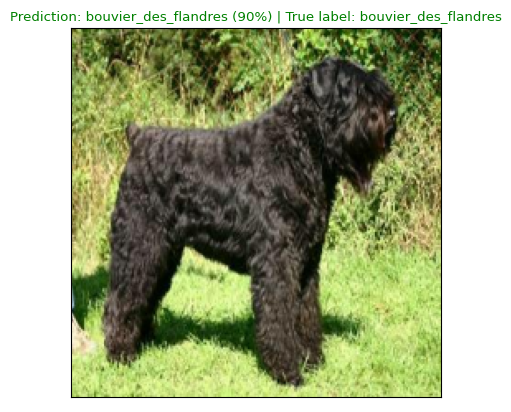

In [ ]:
# INTERESTING
plot_pred(predictions, val_labels, val_images, 0)

### 3.4. Saving and reloading the trained model

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model

  print(f"Saving model to: {model_path}...")

  model.save(model_path)

  return model_path

# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from {model_path}")

  model = tf.keras.models.load_model(
      model_path,
      custom_objects={"KerasLayer": hub.KerasLayer}
  )

  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenet")

Saving model to: models/20221217-18571671296255-1000-images-mobilenet.h5...


'models/20221217-18571671296255-1000-images-mobilenet.h5'

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model("models/20221217-18571671296255-1000-images-mobilenet.h5")

Loading saved model from models/20221217-18571671296255-1000-images-mobilenet.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 4s 479ms/step - loss: 1.3826 - accuracy: 0.6200


[1.3825546503067017, 0.6200000047683716]

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 4s 479ms/step - loss: 1.3826 - accuracy: 0.6200


[1.3825546503067017, 0.6200000047683716]

### 3.5. Training a big model (on the full data)

In [ ]:
# Create a data batch with the full data set
full_data = create_data_batches(x, y)

full_data

Creating training data batches...


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a model for full model
full_model = create_model()

# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=3
)

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Fit the full model to the full data
full_model.fit(
    x=full_data,
    epochs=NUM_EPOCHS,
    callbacks=[full_model_tensorboard, full_model_early_stopping]
)

Epoch 1/100
320/320 [==============================] - 172s 528ms/step - loss: 1.3462 - accuracy: 0.6687
Epoch 2/100
320/320 [==============================] - 169s 527ms/step - loss: 0.4049 - accuracy: 0.8795
Epoch 3/100
320/320 [==============================] - 171s 534ms/step - loss: 0.2405 - accuracy: 0.9331
Epoch 4/100
320/320 [==============================] - 169s 529ms/step - loss: 0.1550 - accuracy: 0.9632
Epoch 5/100
320/320 [==============================] - 171s 534ms/step - loss: 0.1054 - accuracy: 0.9796
Epoch 6/100
320/320 [==============================] - 171s 534ms/step - loss: 0.0759 - accuracy: 0.9881
Epoch 7/100
320/320 [==============================] - 171s 533ms/step - loss: 0.0603 - accuracy: 0.9904
Epoch 8/100
320/320 [==============================] - 172s 537ms/step - loss: 0.0470 - accuracy: 0.9933
Epoch 9/100
320/320 [==============================] - 172s 536ms/step - loss: 0.0387 - accuracy: 0.9950
Epoch 10/100
320/320 [==============================] -

In [ ]:
# Save the full model
save_model(full_model, suffix="full-images-mobilenet")

Saving model to: models/20221217-19561671299803-full-images-mobilenet.h5...


'models/20221217-19561671299803-full-images-mobilenet.h5'

In [ ]:
# Load in the full model
loaded_full_model = load_model("models/20221217-19561671299803-full-images-mobilenet.h5")

Loading saved model from models/20221217-19561671299803-full-images-mobilenet.h5


### 3.6. Making predictions on the test data set

In [ ]:
# Load test image filenames
test_path = "data_set/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['data_set/test/266490a2b053a4a3bf68e779f28fb5a9.jpg',
 'data_set/test/dae9fd18836d8df20989ef0101771d4b.jpg',
 'data_set/test/079a40f22b0fad9a66f76797b62bb930.jpg',
 'data_set/test/ab8462f9a501d362041d47582fddc9ad.jpg',
 'data_set/test/8895089b432e020cc42e6262b5a1c2dd.jpg',
 'data_set/test/985ae7fc271ac4a0d131e546c0f95bb6.jpg',
 'data_set/test/77c1ab99cffb817d54fb14f229aeb118.jpg',
 'data_set/test/ad7e50abca9b7c6a88b63946c5bbe493.jpg',
 'data_set/test/d61a09cecf56666cdb315ebce4b93c43.jpg',
 'data_set/test/cb120c57904e8c0694bbe259c58a873c.jpg']

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

test_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 180s 555ms/step


#### Preparing test dataset predictions for Kaggle

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=['id'] + list(unique_breeds))

preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [ ]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,266490a2b053a4a3bf68e779f28fb5a9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dae9fd18836d8df20989ef0101771d4b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,079a40f22b0fad9a66f76797b62bb930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ab8462f9a501d362041d47582fddc9ad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8895089b432e020cc42e6262b5a1c2dd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,266490a2b053a4a3bf68e779f28fb5a9,1.113335e-09,6.930732e-06,2.563104e-08,5.315631e-07,7.217157e-12,5.936792e-06,2.481570e-12,4.337933e-11,1.106880e-03,...,1.123333e-09,2.035649e-09,1.842634e-05,1.063408e-06,1.039085e-06,1.119477e-11,1.606886e-08,1.256692e-06,1.767722e-09,7.645246e-12
1,dae9fd18836d8df20989ef0101771d4b,1.519670e-02,4.501421e-04,2.141472e-05,2.590447e-07,6.718902e-07,7.596133e-08,6.592411e-03,6.379500e-09,1.532478e-07,...,3.794229e-07,5.200246e-07,8.769639e-07,6.637682e-05,1.442583e-04,1.188365e-09,4.332247e-06,3.206950e-06,1.731028e-06,5.507044e-08
2,079a40f22b0fad9a66f76797b62bb930,1.638407e-07,1.377482e-10,6.198287e-12,3.701368e-10,1.282990e-10,3.459939e-10,1.736387e-11,4.887462e-11,2.514857e-11,...,2.759527e-12,8.896740e-12,1.328901e-11,2.964115e-10,4.282432e-10,2.511285e-12,6.231122e-12,1.005310e-12,8.477872e-12,1.766930e-11
3,ab8462f9a501d362041d47582fddc9ad,4.136138e-10,2.612665e-08,6.255276e-12,2.762284e-08,7.534287e-12,1.426580e-08,3.493278e-09,4.839284e-12,4.443746e-10,...,5.367990e-09,1.814910e-10,3.636071e-10,3.694434e-08,9.575785e-11,2.442898e-07,2.870085e-09,2.371824e-11,9.996184e-13,1.719899e-07
4,8895089b432e020cc42e6262b5a1c2dd,1.486058e-10,3.993201e-10,7.947358e-09,1.184623e-11,3.220597e-09,1.347841e-08,2.450898e-07,2.545734e-04,2.478017e-06,...,1.262769e-09,1.095824e-07,1.580442e-09,2.124891e-10,1.895878e-10,2.546674e-08,2.150379e-08,3.899708e-07,3.249503e-07,1.282793e-11


In [ ]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("full_model_predictions_submission.csv", index=False)

https://www.kaggle.com/competitions/dog-breed-identification/leaderboard

### 3.7. Making predictions on custom images

To make predictions on custom images, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [ ]:
# INTERESTING
# Get custom image filepaths
custom_path = "custom_images/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

custom_image_paths

['custom_images/WhatsApp Image 2022-12-17 at 20.40.07.jpeg',
 'custom_images/WhatsApp Image 2022-12-17 at 20.40.07 (4).jpeg',
 'custom_images/WhatsApp Image 2022-12-17 at 20.40.07 (2).jpeg',
 'custom_images/WhatsApp Image 2022-12-17 at 20.40.07 (5).jpeg',
 'custom_images/WhatsApp Image 2022-12-17 at 20.40.07 (3).jpeg',
 'custom_images/WhatsApp Image 2022-12-17 at 20.40.07 (1).jpeg']

In [ ]:
# INTERESTING
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [ ]:
# INTERESTING
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 0s 173ms/step


In [ ]:
# INTERESTING
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]

custom_pred_labels

['malinois',
 'german_shepherd',
 'german_shepherd',
 'german_shepherd',
 'german_shepherd',
 'german_shepherd']

In [ ]:
# INTERESTING
# Get custom images (our 'unbatch()' function won't work since there aren't labels)
custom_images = []

# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

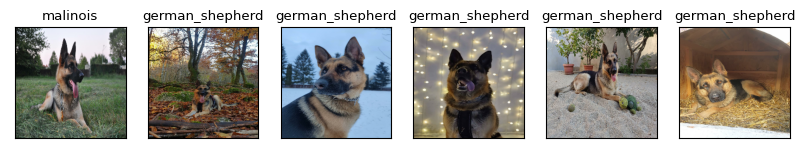

In [ ]:
# INTERESTING
# Check custom image predictions
plt.figure(figsize=(10, 10))

for i, image in enumerate(custom_images):
  plt.subplot(1, len(custom_images), i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

## 4. Conclusions

* Formatting and preprocessing the data can take a lot of time.  
* Using a pre-trained model can help you achieve a better score.  
* Use a small amount of data for experimentations.  
* Always save the model after training (especially if you did it on all the data).  
* Predictions should be in a user-friendly format.  
* If the AI model was wrong at a prediction the predicted breed was very similar to the real one (in most cases).